In [3]:
import os
from matplotlib import pyplot as plt
import numpy as np

from tensorflow.keras.models import Sequential 
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop


from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

#from keras.datasets import imdb

In [4]:
data_dir = '/home/silvio/dataset/jena/'

# dataset de dados climáticos
## Colunas
* Date Time 
* p (mbar)
* T (degC)
* Tpot (K)
* Tdew (degC)
* rh (%)
* VPmax (mbar)
* VPact (mbar)
* VPdef (mbar)
* sh (g/kg)
* H2OC (mmol/mol)
* rho (g/m**3)
* wv (m/s)
* max. wv (m/s)
* wd (deg)


In [5]:
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')
f = open(fname)
data = f.read()
f.close()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [6]:

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [7]:
float_data.shape

(420451, 14)

In [8]:
float_data=float_data[0:400,]
float_data.shape

(400, 14)

# Coluna Temperatura (normalizada)

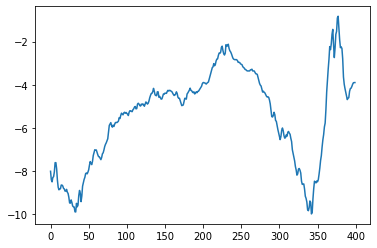

In [9]:

temp = float_data[:, 1] 
plt.plot(range(len(temp)), temp)

# amostra de intervalo de datas

In [11]:
plt.plot(range(1440), temp[:1440])

# normalização

In [12]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

# Função para auxiliar na criação de dados de treino, teste e validação
* palavra reservad yield : suporte para criação de objetos do tipo generator
* Modeo mais eficiente de leitura de dados sem comprometer a memória

In [13]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets


In [16]:
#lookback = 1440
lookback = 30
step = 6
#delay = 144
delay = 10
#batch_size = 128
batch_size = 2

In [17]:
train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200,#200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200,#200001,
                    max_index=250,#300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=250,#300001,
                     max_index=300,#None,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback)

test_steps = (len(float_data) - 300001 - lookback)

In [18]:
print(type(val_gen))
samples, targets = next(val_gen)
print(samples.shape)
print(targets.shape)

<class 'generator'>
(2, 5, 14)
(2,)


# Percorrendo um objeto generator
* 

In [19]:
 def evaluate_naive_method():
            batch_maes = []
            for step in range(val_steps):
                samples, targets = next(val_gen)
                preds = samples[:, -1, 1]
                mae = np.mean(np.abs(preds - targets))
                batch_maes.append(mae)
            print(np.mean(batch_maes))
        


In [20]:
evaluate_naive_method()

0.2687811214600597


In [21]:
celsius_mae = 0.29 * std[1]
celsius_mae

0.6311839636721908

In [22]:
#np.mean(np.abs(preds - targets))

# função para plotar loss de treino e teste

In [23]:
def plot_loss(history):
    loss = history.history['loss']
    #val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    #plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

# Exemplos de Redes neurais para atacar o problema de série temporal
* MLP

In [24]:
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1]))) 
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae') 


In [25]:
epochs=20
steps_p_epochs=200

#steps_p_epochs=500
#epochs=20

history = model.fit_generator(train_gen,
steps_per_epoch=steps_p_epochs, epochs=epochs)#, validation_data=val_gen, validation_steps=val_steps)

/home/silvio/.conda/envs/fiep-2021/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
200/200 [==============================] - 1s 3ms/step - loss: 0.2924
Epoch 2/20
200/200 [==============================] - 1s 3ms/step - loss: 0.1606
Epoch 3/20
200/200 [==============================] - 1s 3ms/step - loss: 0.1442
Epoch 4/20
200/200 [==============================] - 1s 3ms/step - loss: 0.1423
Epoch 5/20
200/200 [==============================] - 1s 3ms/step - loss: 0.1185
Epoch 6/20
200/200 [==============================] - 1s 3ms/step - loss: 0.1199
Epoch 7/20
200/200 [==============================] - 1s 3ms/step - loss: 0.1104
Epoch 8/20
200/200 [==============================] - 1s 3ms/step - loss: 0.0953
Epoch 9/20
200/200 [==============================] - 1s 3ms/step - loss: 0.0894
Epoch 10/20
200/200 [==============================] - 1s 3ms/step - loss: 0.0882
Epoch 11/20
200/200 [==============================] - 1s 3ms/step - loss: 0.1164
Epoch 12/20
200/200 [==============================] - 1s 3ms/step - loss: 0.0915
Epoch 13/20
200/200 [====

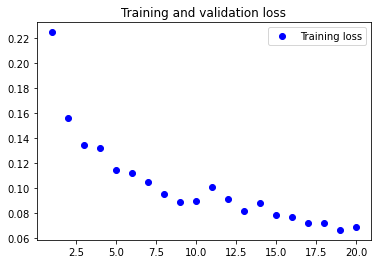

In [26]:
plot_loss(history)

# Usando camada GRU

In [27]:

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')


In [28]:
history = model.fit_generator(train_gen,
                            steps_per_epoch=500, epochs=20)#, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 5s 5ms/step - loss: 0.1405
Epoch 2/20
500/500 [==============================] - 3s 5ms/step - loss: 0.0884
Epoch 3/20
500/500 [==============================] - 3s 5ms/step - loss: 0.0704
Epoch 4/20
500/500 [==============================] - 3s 5ms/step - loss: 0.0688
Epoch 5/20
500/500 [==============================] - 3s 5ms/step - loss: 0.0682
Epoch 6/20
500/500 [==============================] - 3s 5ms/step - loss: 0.0583
Epoch 7/20
500/500 [==============================] - 3s 5ms/step - loss: 0.0571
Epoch 8/20
500/500 [==============================] - 3s 5ms/step - loss: 0.0542
Epoch 9/20
500/500 [==============================] - 3s 5ms/step - loss: 0.0521
Epoch 10/20
500/500 [==============================] - 3s 5ms/step - loss: 0.0497
Epoch 11/20
500/500 [==============================] - 3s 5ms/step - loss: 0.0488
Epoch 12/20
500/500 [==============================] - 3s 5ms/step - loss: 0.0443
Epoch 13/20
500/500 [====

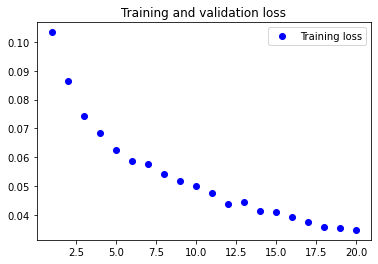

In [29]:
plot_loss(history)

# GRU 
* dropout
* recurrent_dropout

In [30]:
model = Sequential()
model.add(layers.GRU(32,
                    dropout=0.2,
                    recurrent_dropout=0.2,
                    input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')        

In [31]:
history = model.fit_generator(train_gen,
                                      steps_per_epoch=500,
                                      epochs=40)#,
                                      #validation_data=val_gen,
                                      #validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 14s 26ms/step - loss: 0.1898
Epoch 2/40
500/500 [==============================] - 13s 26ms/step - loss: 0.1180
Epoch 3/40
500/500 [==============================] - 13s 26ms/step - loss: 0.1055
Epoch 4/40
500/500 [==============================] - 13s 25ms/step - loss: 0.1006
Epoch 5/40
500/500 [==============================] - 13s 25ms/step - loss: 0.0931
Epoch 6/40
500/500 [==============================] - 12s 25ms/step - loss: 0.0839
Epoch 7/40
500/500 [==============================] - 12s 25ms/step - loss: 0.0901
Epoch 8/40
500/500 [==============================] - 12s 25ms/step - loss: 0.0849
Epoch 9/40
500/500 [==============================] - 12s 25ms/step - loss: 0.0826
Epoch 10/40
500/500 [==============================] - 13s 25ms/step - loss: 0.0765
Epoch 11/40
500/500 [==============================] - 13s 25ms/step - loss: 0.0750
Epoch 12/40
500/500 [==============================] - 12s 25ms/step - loss: 0.0757
E

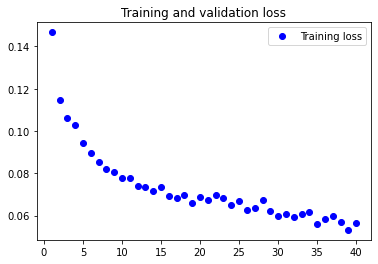

In [32]:
plot_loss(history)

# GRU 
* Duas camadas recorrentes
* return_sequences

In [33]:
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')

In [34]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40)#,
                              #validation_data=val_gen,
                              #validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 26s 46ms/step - loss: 0.1332
Epoch 2/40
500/500 [==============================] - 22s 44ms/step - loss: 0.0967
Epoch 3/40
500/500 [==============================] - 22s 44ms/step - loss: 0.1014
Epoch 4/40
500/500 [==============================] - 21s 43ms/step - loss: 0.0808
Epoch 5/40
500/500 [==============================] - 22s 43ms/step - loss: 0.0824
Epoch 6/40
500/500 [==============================] - 22s 43ms/step - loss: 0.0756
Epoch 7/40
500/500 [==============================] - 22s 43ms/step - loss: 0.0701
Epoch 8/40
500/500 [==============================] - 22s 44ms/step - loss: 0.0726
Epoch 9/40
500/500 [==============================] - 22s 44ms/step - loss: 0.0715
Epoch 10/40
500/500 [==============================] - 22s 44ms/step - loss: 0.0698
Epoch 11/40
500/500 [==============================] - 22s 44ms/step - loss: 0.0792
Epoch 12/40
500/500 [==============================] - 22s 44ms/step - loss: 0.0657
E

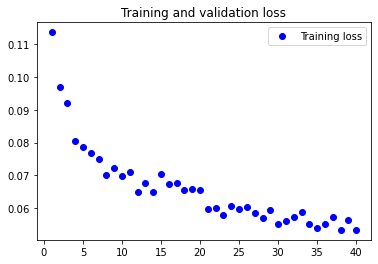

In [35]:
plot_loss(history)

# GRU bidirecionais
* Camada LSTM
* Embedding

# GRU
* Camadas bidirecionais

In [36]:
model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40)#,
                              #validation_data=val_gen,
                              #validation_steps=val_steps)


Epoch 1/40
500/500 [==============================] - 6s 8ms/step - loss: 0.1428
Epoch 2/40
500/500 [==============================] - 4s 8ms/step - loss: 0.0869
Epoch 3/40
500/500 [==============================] - 4s 8ms/step - loss: 0.0733
Epoch 4/40
500/500 [==============================] - 4s 8ms/step - loss: 0.0708
Epoch 5/40
500/500 [==============================] - 4s 8ms/step - loss: 0.0630
Epoch 6/40
500/500 [==============================] - 4s 8ms/step - loss: 0.0587
Epoch 7/40
500/500 [==============================] - 4s 8ms/step - loss: 0.0579
Epoch 8/40
500/500 [==============================] - 4s 8ms/step - loss: 0.0553
Epoch 9/40
500/500 [==============================] - 4s 8ms/step - loss: 0.0540
Epoch 10/40
500/500 [==============================] - 4s 8ms/step - loss: 0.0489
Epoch 11/40
500/500 [==============================] - 4s 8ms/step - loss: 0.0482
Epoch 12/40
500/500 [==============================] - 4s 8ms/step - loss: 0.0450
Epoch 13/40
500/500 [====

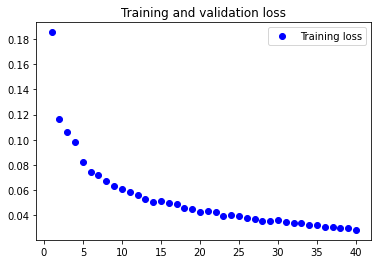

In [83]:
plot_loss(history)

0    1
dtype: int64